In [1]:
# Now we will begin to start implementing the ML algorithms. We will be eventually creating a pipeline for bagging and
# ensembling several estimators in order to create the most robust algorith.

In [2]:
# need to install sklearn-pandas dataframe manager via:
# pip install sklearn-pandas

In [3]:
# As usual, start out by importing the libraries we expect to use
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# setting up steps to import and split our data for the algorithm. However, we are going to scale our data in order to be more
# effective with the various ML algorithms
# next time set index to false for to_csv
df = pd.read_csv('ml_ready.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [5]:
# next time in original data exploration/transformation functions, incorporate dtype switch
# creating complete list of categorical variables, afterwards will re-merge df
categorical = []
for x in list(df.columns):
    if 'Non' in x:
        categorical.append(x)
    elif 'Has' in x:
        categorical.append(x)
    elif 'SubClass' in x:
        categorical.append(x)
    elif 'SaleConditionNor' in x:
        categorical.append(x)
    elif 'LandSlopeGtl' in x:
        categorical.append(x)
    elif 'LotShapeReg' in x:
        categorical.append(x)
    elif 'HeatingGas' in x:
        categorical.append(x)      
    elif 'CentralAir' in x:
        categorical.append(x)
    elif 'TotRmsAbvGrd' in x:
        categorical.append(x)
    
for x in list(df.select_dtypes(include='object').columns):
    categorical.append(x)
categorical = list(set(categorical))

# merging converted dfs
df[categorical] = df[categorical].astype('object')
df_num = df.drop(categorical, axis = 1)
df = pd.concat([df[categorical],df_num], axis=1)

In [6]:
# creating the X and y variables
X = df.drop(['LogSale','SalePrice'],axis=1)
X = pd.get_dummies(X,drop_first=True)
y = df['LogSale']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [8]:
# re-separating the categorical and numerical columns and then implementing column transformer for the pipeline

# numerical transformer
numerical = list(X.select_dtypes(include = ['int64', 'float64']).columns)
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median')),
                                ('scaler', StandardScaler())])
#categorical transformer
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median')),
                                ('onehot', OneHotEncoder())])

# preprocessing function to be implemented into the pipeline
preprocess = ColumnTransformer(transformers=
                              [('num', numerical_transformer, numerical)])

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
#creating pipeline steps, later will implement for various regressors for stacking and boosting
classifier = RandomForestRegressor()
steps = [
    ('preprocessor', preprocess),
    ('clf', classifier)
]
pipe = Pipeline(steps)

In [11]:
# creating the training split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

In [13]:
classifier.fit(X_train,y_train)
print(np.sqrt(mean_squared_log_error(y_test,classifier.predict(X_test))))
print(r2_score(y_test, classifier.predict(X_test)))

0.011666155564961178
0.8577203144587139


C:\Users\myate\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [14]:
pipe.fit(X_train,y_train)
print(np.sqrt(mean_squared_log_error(y_test,pipe.predict(X_test))))
print(r2_score(y_test, pipe.predict(X_test)))

0.010774136587859301
0.8792625751418299


In [15]:
# setting up parameters to test in the grid search function to be implemented later on
params = {'clf__max_depth': [2,5,8,10,15]}
#          'cv': [3,4,5]}

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
grid = GridSearchCV(pipe, param_grid = params, cv=10, return_train_score=True)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'clf__max_depth': 15}


In [18]:
# we need to check for overfitting. 99% explanation seems extremely high
results = pd.DataFrame(grid.cv_results_)
print(results[['mean_test_score','std_test_score','mean_train_score','std_train_score']])
print(results['mean_test_score']-results['mean_train_score'])
print()
print('It appears the model might be overfitting a bit to the training data. Lets take some different approaches in a moment.')

   mean_test_score  std_test_score  mean_train_score  std_train_score
0         0.629373        0.053390          0.668658         0.010174
1         0.818221        0.040402          0.900405         0.002834
2         0.850046        0.047496          0.960106         0.001783
3         0.847640        0.042315          0.969738         0.001634
4         0.850433        0.038309          0.974840         0.001502
0   -0.039285
1   -0.082184
2   -0.110060
3   -0.122098
4   -0.124408
dtype: float64

It appears the model might be overfitting a bit to the training data. Lets take some different approaches in a moment.


In [19]:
from sklearn.feature_selection import SelectKBest, f_regression

The following are the 15 most important features for regression.

['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'GarageCars', 'GarageArea', 'BsmtCond*BsmtQual', 'ExterCond*ExterQual', 'TotalBsmtSFNegSq', 'GrLivAreaNegSq']

The following heatmap shows the correlation between the top 15 regressors and log sale price.


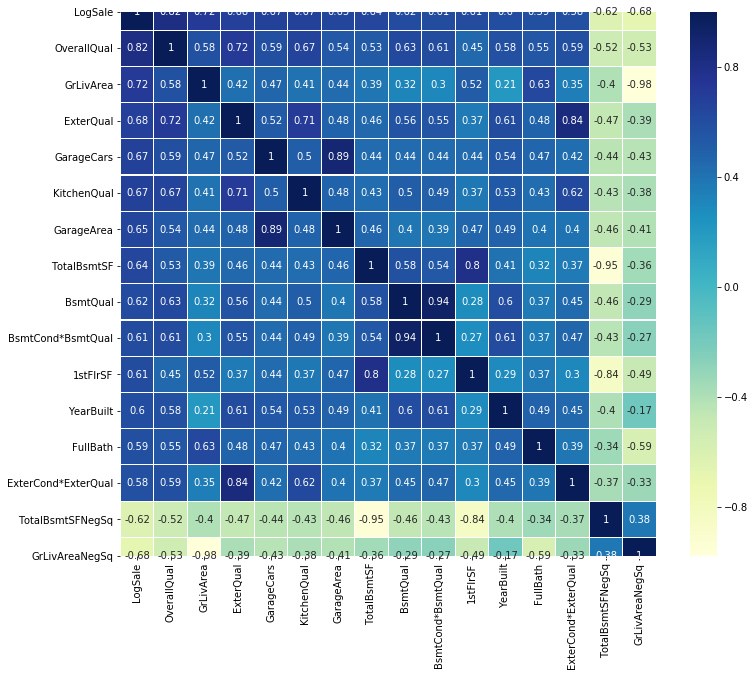

In [20]:
# Let's find out what the most important features in the model were
kbest = SelectKBest(f_regression, 15).fit(X_train,y_train)
mask = kbest.get_support()
cols = X_train.columns[mask]
k15 = pd.DataFrame(kbest.transform(X_train), columns = cols)


print('The following are the 15 most important features for regression.')
print()
print(list(cols))
print()
print('The following heatmap shows the correlation between the top 15 regressors and log sale price.')
cols = list(cols)
cols.append('LogSale')

# setup for organized heatmap
k=16
features = df[cols].corr().nlargest(k, 'LogSale')['LogSale'].index 
  
cm = np.corrcoef(df[cols][features].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = features.values,  
                              xticklabels = features.values,
           annot = True) 

In [21]:
X_best = df[list(k15.columns)]
y = df['LogSale']
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = .30)

numerical = list(X_best.select_dtypes(include = ['int64', 'float64']).columns)
scaler = StandardScaler()
pipe_steps = [('scaler', StandardScaler()),
             ('clf', RandomForestRegressor())]
pipe = Pipeline(pipe_steps)

In [22]:
grid = GridSearchCV(pipe, param_grid = params, cv = 5, return_train_score=True)
grid.fit(X_train,y_train)
results = pd.DataFrame(grid.cv_results_)
print(results[['mean_test_score','std_test_score','mean_train_score','std_train_score']])
print(results['mean_test_score']-results['mean_train_score'])

   mean_test_score  std_test_score  mean_train_score  std_train_score
0         0.624558        0.069101          0.663738         0.010202
1         0.797626        0.041669          0.885077         0.006817
2         0.818841        0.036791          0.945997         0.002853
3         0.817230        0.034753          0.961338         0.002293
4         0.817494        0.030527          0.969275         0.002385
0   -0.039180
1   -0.087451
2   -0.127156
3   -0.144108
4   -0.151781
dtype: float64


In [23]:
# reimporting and fixing the data to prevent leakage

df = pd.read_csv('ml_ready.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

categorical = []
for x in list(df.columns):
    if 'Non' in x:
        categorical.append(x)
    elif 'Has' in x:
        categorical.append(x)
    elif 'SubClass' in x:
        categorical.append(x)
    elif 'SaleConditionNor' in x:
        categorical.append(x)
    elif 'LandSlopeGtl' in x:
        categorical.append(x)
    elif 'LotShapeReg' in x:
        categorical.append(x)
    elif 'HeatingGas' in x:
        categorical.append(x)      
    elif 'CentralAir' in x:
        categorical.append(x)
for x in list(df.select_dtypes(include='object').columns):
    categorical.append(x)
categorical = list(set(categorical))

# merging converted dfs
df[categorical] = df[categorical].astype('object')
df_num = df.drop(categorical, axis = 1)
df = pd.concat([df[categorical],df_num], axis=1)

X = df.drop(['LogSale','SalePrice'],axis=1)
X = pd.get_dummies(X,drop_first=True)
y = df['LogSale']

In [24]:
# testing this model on 25 regressors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
kbest = SelectKBest(f_regression, 25).fit(X_train,y_train)
mask = kbest.get_support()
cols = X_train.columns[mask]
k25 = pd.DataFrame(kbest.transform(X_train), columns = cols)

X_25 = X_train[list(k25.columns)]
y = df['LogSale']
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = .30)

categorical = list(X_best.select_dtypes(include = ['object']).columns)
numerical = list(X_best.select_dtypes(include = ['int64', 'float64']).columns)
scaler = StandardScaler()
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median')),
                                ('onehot', OneHotEncoder())])
preprocess = ColumnTransformer(transformers=
                              [('num', scaler, numerical),
                              ('cat', categorical_transformer, categorical)])

pipe_steps = [('preprocess', preprocess),
             ('clf', RandomForestRegressor())]
pipe = Pipeline(pipe_steps)

grid = GridSearchCV(pipe, param_grid = params, cv = 5, return_train_score=True)
grid.fit(X_train,y_train)
results = pd.DataFrame(grid.cv_results_)
print(results[['mean_test_score','std_test_score','mean_train_score','std_train_score']])
print(results['mean_test_score']-results['mean_train_score'])

   mean_test_score  std_test_score  mean_train_score  std_train_score
0         0.671366        0.021070          0.687862         0.004995
1         0.820274        0.014893          0.887935         0.002430
2         0.826113        0.018830          0.945477         0.002400
3         0.830170        0.015289          0.959611         0.002474
4         0.829970        0.018192          0.968235         0.002169
0   -0.016496
1   -0.067661
2   -0.119364
3   -0.129441
4   -0.138265
dtype: float64


In [25]:
#resetting train/test sets

X = df.drop(['LogSale','SalePrice'],axis=1)
X = pd.get_dummies(X,drop_first=True)
y = df['LogSale']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

In [26]:
# Still having issues with overfitting with our best parameters, although it appears our full model does better with variance
# So I'll play around with some decision tree paramenters to see if I can correct this over-tuning

clf_rf = RandomForestRegressor(max_depth=5, max_features=25)
params = {'clf__max_depth': range(5,26,5),
         'clf__max_features': range(5,20,5),
          'clf__n_estimators': [5,10,15]
         }
grid = GridSearchCV(pipe, param_grid = params, cv = 5, return_train_score=True)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'clf__max_depth': 20, 'clf__max_features': 10, 'clf__n_estimators': 10}


In [27]:
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_rf.fit(X_train,y_train)
preds = clf_rf.predict(X_test)
print(np.sqrt(mean_squared_log_error(y_test,preds)))
print(r2_score(y_test, preds))

0.01110889850896641
0.8590082646708039


In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
print(cross_val_score(clf_rf, X_train, y_train, scoring = 'r2', cv =5))
print(cross_val_score(clf_rf, X_train, y_train, scoring = 'neg_mean_squared_log_error', cv =5))

[0.75784154 0.81976943 0.84105252 0.86327124 0.80387591]
[-0.00015186 -0.00014753 -0.00012995 -0.00015729 -0.00025371]


In [30]:
from sklearn.linear_model import LinearRegression, Ridge

In [31]:
# lets try some other models 
classifier = LinearRegression()
pipe_steps = [('preprocess', preprocess),
              ('clf', classifier)]
pipe = Pipeline(pipe_steps)


print(cross_val_score(pipe, X_train, y_train, scoring = 'r2', cv =5))
print(cross_val_score(pipe, X_train, y_train, scoring = 'neg_mean_squared_log_error', cv =5))

[0.82387932 0.83585426 0.83744289 0.86733244 0.83640997]
[-0.0001331  -0.00013914 -0.00013721 -0.00013367 -0.00019113]


In [32]:
classifier = Ridge()
pipe_steps = [('preprocess', preprocess),
              ('clf', Ridge())]

pipe = Pipeline(pipe_steps)
params = {'clf__alpha': [0.1,1,5,10]}

grid = GridSearchCV(pipe, param_grid = params, cv = 5, return_train_score=True)
grid.fit(X_train,y_train)
print(grid.best_params_)


{'clf__alpha': 10}


In [33]:
print(cross_val_score(pipe, X_train, y_train, scoring = 'r2', cv =5))
print(cross_val_score(pipe, X_train, y_train, scoring = 'neg_mean_squared_log_error', cv =5))

[0.82397913 0.83554675 0.83795108 0.867427   0.8370077 ]
[-0.00013302 -0.00013944 -0.00013681 -0.00013359 -0.00019056]


In [34]:
classifiers = [LinearRegression(), Ridge()]
pipe_steps = [('preprocess', preprocess),
              ('clf', x)]
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    print(cross_val_score(pipe, X_train, y_train, scoring = 'r2', cv =5))
    print(cross_val_score(pipe, X_train, y_train, scoring = 'neg_mean_squared_log_error', cv =5))

[0.82387932 0.83585426 0.83744289 0.86733244 0.83640997]
[-0.0001331  -0.00013914 -0.00013721 -0.00013367 -0.00019113]
[0.82397913 0.83554675 0.83795108 0.867427   0.8370077 ]
[-0.00013302 -0.00013944 -0.00013681 -0.00013359 -0.00019056]


In [35]:
# going to store the predictions from the classifiers to check their correlations, if we are going to create a stacked
# regressor then we are going to want less correlated predictors

classifiers = [LinearRegression(), Ridge(), RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)]
pipe_steps = [('preprocess', preprocess),
              ('clf', x)]
def transformer(x):
    return np.exp(x)

predictions = []
pred_cols = []
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_test)))

In [36]:
for x in range(0,3):
    corr_test = pd.DataFrame([predictions[x],transformer(y_test)], index = ['preds','y_test']).transpose()
    print(pred_cols[x])
    print(np.sqrt(mean_squared_log_error(transformer(y_test),predictions[x])))
    print(r2_score(transformer(y_test),predictions[x]))
    print()

pred_LinearRegression
0.13633966155332797
0.8846414403645152

pred_Ridge
0.136341273475315
0.8848522507952289

pred_RandomForestRegressor
0.14421819224353766
0.8647316101798813



In [37]:
corr_test = pd.DataFrame(predictions, index = pred_cols).transpose()
corr_test.corr()

,pred_LinearRegression,pred_Ridge,pred_RandomForestRegressor
pred_LinearRegression,1.000000,0.999993,0.975587
pred_Ridge,0.999993,1.000000,0.975560
pred_RandomForestRegressor,0.975587,0.975560,1.000000


In [38]:
# going to implement an adaboost algorithm, but will need a weak regresser (i.e. one that performs slightly above 50% r2)
# also going to create several other algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [39]:
clf_dtr = DecisionTreeRegressor(max_depth=9, min_samples_leaf=3)
pipe_steps = [('preprocess', preprocess),
              ('clf', clf_dtr)]
print(cross_val_score(pipe, X_train, y_train, scoring = 'r2', cv =5))
print(cross_val_score(pipe, X_train, y_train, scoring = 'neg_mean_squared_log_error', cv =5))

[0.80125402 0.82530562 0.8528099  0.85858818 0.80819246]
[-0.00014247 -0.00015549 -0.00013045 -0.0001355  -0.00021178]


In [40]:
# going to create a function so I can stop copying and pasting code. This will take a list of clf_func and print out their
# scores

def custom_pipeline(clf_func):
    
    predictions = []

    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                    ('clf', clf_func)])
    pred_name = 'pred_' + str(clf_func)[0: str(clf_func).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_test)))

    # want to print out their cross val scores as well, although they are not transformed yet

    print(cross_val_score(pipe, X_train, y_train, scoring = 'r2', cv =5))
    print(cross_val_score(pipe, X_train, y_train, scoring = 'neg_mean_squared_log_error', cv =5))

    print()
    print(np.sqrt(mean_squared_log_error(transformer(y_test),predictions[0])))
    print(r2_score(transformer(y_test),predictions[0]))
    print()

In [41]:
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
custom_pipeline(clf_dtr)

[0.48017167 0.54326414 0.59290311 0.59480719 0.6032591 ]
[-0.00038968 -0.00038727 -0.0003397  -0.00041475 -0.0004503 ]

0.231303055212383
0.6313201173812278



In [42]:
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 200, learning_rate=.25)
custom_pipeline(clf_ada)

[0.70545531 0.74511651 0.73013297 0.76279908 0.72529602]
[-0.00022362 -0.00020246 -0.00022968 -0.00024217 -0.00030803]

0.18633806842817324
0.7666536250835675



In [43]:
# it appears this ada boost does well for the bias and test performance, although it would still be nice to lower the variance.
# we will implement the Support Vector regressor and then stack our regressors after measuring their correlations

clf_svm = SVR()
params = {'clf__C': [0.1,0.5,1,5,10,20],
          'clf__kernel': ['rbf', 'linear']}
pipe_steps = [('preprocess', preprocess),
              ('clf', clf_svm)]
pipe = Pipeline(pipe_steps)
grid = GridSearchCV(pipe, param_grid = params, cv = 5, return_train_score=True)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [44]:
clf_svm = SVR(C=10, kernel = 'linear')
custom_pipeline(clf_svm)

[0.82927952 0.83024769 0.83942712 0.8702835  0.83801226]
[-0.000129   -0.00014412 -0.00013568 -0.00013091 -0.00018957]

0.1370411548537589
0.8843961076738571



In [45]:
clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svr = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
pipe_steps = [('preprocess', preprocess),
              ('clf', x)]
def transformer(x):
    return np.exp(x)

predictions = []
pred_cols = []
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_test)))
for x in range(0,len(classifiers)):
    print(pred_cols[x])
    print(np.sqrt(mean_squared_log_error(transformer(y_test),predictions[x])))
    print(r2_score(transformer(y_test),predictions[x]))
    print()
corr_test = pd.DataFrame(predictions, index = pred_cols).transpose()
corr_test.corr()
corr_test.head()

pred_LinearRegression
0.13633966155332797
0.8846414403645152

pred_Ridge
0.136341273475315
0.8848522507952289

pred_RandomForestRegressor
0.14403304677535858
0.8664968947373548

pred_AdaBoostRegressor
0.1860988510695479
0.76743189234411

pred_SVR
0.1370411548537589
0.8843961076738571



,pred_LinearRegression,pred_Ridge,pred_RandomForestRegressor,pred_AdaBoostRegressor,pred_SVR
0,281570.741019,281487.719839,272465.140872,284506.392462,281494.436581
1,273688.717129,273653.524901,279638.422494,313406.569501,272486.832206
2,245486.599088,246163.117912,260062.569200,187894.643627,248382.658045
3,140539.544662,140357.218487,145923.913063,151673.331080,142849.460186
4,168770.085493,168894.878892,143686.165321,158965.843358,169755.508485


In [46]:
# setting up our first level predictions

clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svm = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
predictions = []
pred_cols = []
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_train)))
    
first_level_preds = pd.DataFrame({'pred_lf': predictions[0],
                                 'pred_ridge': predictions[1],
                                 'pred_rf': predictions[2],
                                 'pred_ada': predictions[3],
                                 'pred_svr': predictions[4]})

X_train_1st = pd.concat([X_train.reset_index(),first_level_preds], axis=1).set_index(keys='index')

In [47]:
stacked = LinearRegression()
stacked.fit(X_train_1st,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
# creating predictions on the test set now for our second level predictions

clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svm = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
predictions = []
pred_cols = []
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_test)))
    
test_level_preds = pd.DataFrame({'pred_lf': predictions[0],
                                 'pred_ridge': predictions[1],
                                 'pred_rf': predictions[2],
                                 'pred_ada': predictions[3],
                                 'pred_svr': predictions[4]})

X_test_1st = pd.concat([X_test.reset_index(),test_level_preds], axis=1).set_index(keys='index')

In [49]:
X_test_1st.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,pred_lf,pred_ridge,pred_rf,pred_ada,pred_svr
index,,,,,,,,,,,,,,,,,,,,,
266,11764,8,7,1999,2007,348.0,4,3,4,3,...,0,0,0,0,0,281570.741019,281487.719839,265445.858094,286699.830439,281494.436581
1144,10475,8,5,2008,2008,72.0,4,3,4,3,...,0,0,0,0,0,273688.717129,273653.524901,287252.645539,314287.934105,272486.832206
1010,15863,7,3,1920,1970,0.0,3,3,3,3,...,0,0,0,0,0,245486.599088,246163.117912,240253.340487,186166.613893,248382.658045
643,17503,6,5,1948,1950,0.0,3,3,3,3,...,0,0,0,0,0,140539.544662,140357.218487,138837.064649,149895.638528,142849.460186
832,45600,6,8,1908,1997,0.0,3,3,3,3,...,0,0,0,0,0,168770.085493,168894.878892,131984.301072,160269.788741,169755.508485


In [50]:
from sklearn.model_selection import cross_validate

In [51]:
results = cross_val_score(stacked, X_train, y_train, scoring = 'r2', cv = 5)
print(results)

[0.80645655 0.87268218 0.86125465 0.93205346 0.88162616]


In [52]:
stacked_preds = stacked.predict(X_test_1st)
print(np.sqrt(mean_squared_log_error(transformer(y_test),transformer(stacked_preds))))
print(r2_score(transformer(y_test),transformer(stacked_preds)))

0.12971994282144916
0.8499221216399293


In [53]:
# let's explore where the algorithm made large errors and see if there are any consistent errors. If so, we can feature engineer
# to accomodate for these where logical patterns exist. Although we need to be careful of overfitting

results = pd.DataFrame({'y_test': transformer(y_test),
             'stacked_preds': transformer(stacked_preds)})
results['error'] = results['stacked_preds']-results['y_test']

In [54]:
# appears we might have to create a squared year_built term to deal with older properties. Maybe interact with OveralQual
large_error_ind = results[abs(results['error'])>50000].index.tolist()
X[list(k25.columns)].loc[large_error_ind]

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,...,GarageArea,Fireplaces*FireplaceQu,BsmtCond*BsmtQual,ExterCond*ExterQual,OverallQual*OverallCond,TotalBsmtSFNegSq,GrLivAreaNegSq,GarageAreaBins_<900,Foundation_PConc,HasOpenPorch_1
832,6,1908,1997,3,3,907,3,1307,2358,3,...,360,4,9,9,48,-822649,-5560164,0,0,1
1295,8,2006,2007,4,5,1795,5,1795,1795,2,...,895,4,15,12,40,-3222025,-3222025,1,1,1
752,7,2004,2005,4,4,1860,5,1836,1836,2,...,484,4,12,12,35,-3459600,-3370896,0,1,1
782,9,2008,2009,5,5,1926,5,1966,3140,3,...,820,8,15,15,45,-3709476,-9859600,1,1,1
468,8,2007,2008,4,5,1705,5,1718,1718,2,...,826,4,15,12,40,-2907025,-2951524,1,1,1
539,8,2006,2006,4,5,1709,5,1717,1717,2,...,908,4,15,12,40,-2920681,-2948089,0,1,1
463,8,2006,2007,4,5,1976,5,1976,1976,2,...,908,5,15,12,40,-3904576,-3904576,0,1,1
1011,8,1993,1993,4,4,1338,5,1352,2520,2,...,796,3,16,16,56,-1790244,-6350400,1,1,1
515,9,2008,2008,5,5,1452,5,1476,2713,2,...,858,4,15,15,45,-2108304,-7360369,1,1,1
134,7,1988,1989,3,3,1907,4,1959,1959,3,...,766,0,9,9,35,-3636649,-3837681,1,0,0


In [55]:
results[results['error']<-50000]

,y_test,stacked_preds,error
832,240000.0,160323.567068,-79676.432932
463,440000.0,348913.503970,-91086.496030
1011,310000.0,257697.321010,-52302.678990
515,446261.0,362080.100698,-84180.899302
213,311500.0,239042.670784,-72457.329216
966,395192.0,328938.170538,-66253.829462
1151,239000.0,184240.653814,-54759.346186
848,250580.0,196335.761651,-54244.238349
1357,377500.0,320104.137487,-57395.862513
1022,262280.0,209076.808641,-53203.191359


In [56]:
large_error_ind = results[results['error']<-100000].index.tolist()
X[list(k25.columns)].loc[large_error_ind]

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,...,GarageArea,Fireplaces*FireplaceQu,BsmtCond*BsmtQual,ExterCond*ExterQual,OverallQual*OverallCond,TotalBsmtSFNegSq,GrLivAreaNegSq,GarageAreaBins_<900,Foundation_PConc,HasOpenPorch_1
471,9,2003,2004,4,5,1792,5,1792,1792,2,...,874,4,15,12,45,-3211264,-3211264,1,1,1
430,10,2008,2008,5,5,3094,5,2402,2402,2,...,672,8,15,15,50,-9572836,-5769604,1,1,1
1343,10,2001,2002,5,5,2633,5,2633,2633,2,...,804,8,15,15,50,-6932689,-6932689,1,1,1


(array([171., 635., 474.,  95.,  23.,  11.,   3.,   4.,   2.,   0.,   2.,
          0.,   3.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1300. ,   5578.9,   9857.8,  14136.7,  18415.6,  22694.5,
         26973.4,  31252.3,  35531.2,  39810.1,  44089. ,  48367.9,
         52646.8,  56925.7,  61204.6,  65483.5,  69762.4,  74041.3,
         78320.2,  82599.1,  86878. ,  91156.9,  95435.8,  99714.7,
        103993.6, 108272.5, 112551.4, 116830.3, 121109.2, 125388.1,
        129667. , 133945.9, 138224.8, 142503.7, 146782.6, 151061.5,
        155340.4, 159619.3, 163898.2, 168177.1, 172456. , 176734.9,
        181013.8, 185292.7, 189571.6, 193850.5, 198129.4, 202408.3,
        206687.2, 210966.1, 215245. ]),
 <a list of 50 Patch objects>)

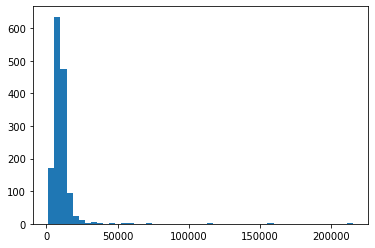

In [57]:
plt.hist(df['LotArea'],  bins = 50)

In [58]:
results[results['error']>50000]

,y_test,stacked_preds,error
1295,147000.0,279792.088677,132792.088677
752,216837.0,277233.154946,60396.154946
782,485000.0,657944.686267,172944.686267
468,297000.0,357126.035449,60126.035449
539,255500.0,359307.415411,103807.415411
134,171000.0,228575.210830,57575.210830
1181,271900.0,337257.508433,65357.508433
731,265979.0,341319.070177,75340.070177
65,180000.0,262697.040625,82697.040625
1287,295493.0,363309.429581,67816.429581


In [59]:
large_error_ind = results[results['error']>50000].index.tolist()
X[list(k25.columns)[12:25]].loc[large_error_ind]

,Fireplaces,FireplaceQu,GarageCars,GarageArea,Fireplaces*FireplaceQu,BsmtCond*BsmtQual,ExterCond*ExterQual,OverallQual*OverallCond,TotalBsmtSFNegSq,GrLivAreaNegSq,GarageAreaBins_<900,Foundation_PConc,HasOpenPorch_1
1295,1,4,3,895,4,15,12,40,-3222025,-3222025,1,1,1
752,1,4,2,484,4,12,12,35,-3459600,-3370896,0,1,1
782,2,4,3,820,8,15,15,45,-3709476,-9859600,1,1,1
468,1,4,3,826,4,15,12,40,-2907025,-2951524,1,1,1
539,1,4,3,908,4,15,12,40,-2920681,-2948089,0,1,1
134,0,0,3,766,0,9,9,35,-3636649,-3837681,1,0,0
1181,1,3,3,701,3,12,12,49,-4656964,-4822416,1,0,1
731,1,4,4,864,4,6,12,49,-1537600,-6969600,1,0,0
65,1,4,2,576,4,12,9,35,-3790809,-4870849,0,0,0
1287,1,4,3,860,4,15,12,40,-2630884,-2656900,1,1,1


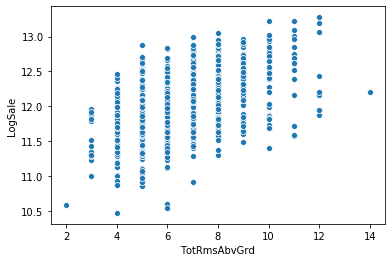

In [60]:
sns.scatterplot(data = df, x = 'TotRmsAbvGrd', y = 'LogSale')

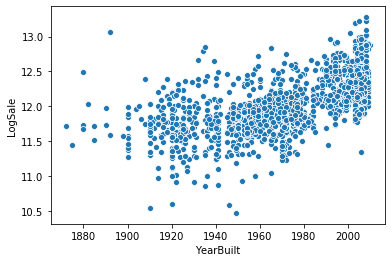

In [61]:
sns.scatterplot(data=df, x = 'YearBuilt', y = 'LogSale')

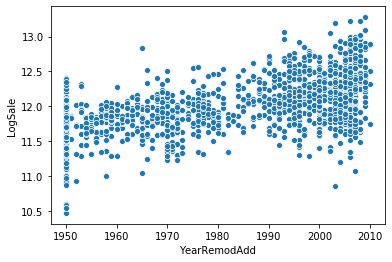

In [62]:
sns.scatterplot(data=df, x = 'YearRemodAdd', y = 'LogSale')

In [63]:
df_error = pd.concat([X_test, results], axis=1)

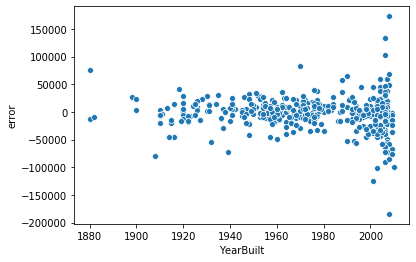

In [64]:
sns.scatterplot(data = df_error, x= 'YearBuilt', y = 'error')

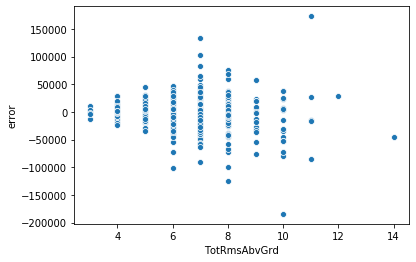

In [65]:
sns.scatterplot(data = df_error, x= 'TotRmsAbvGrd', y = 'error')

In [66]:
df_error[df_error['TotRmsAbvGrd']>9].sort_values('error', ascending = False)[['MasVnrArea','error']]

,MasVnrArea,error
782,860.0,172944.686267
255,270.0,37291.126596
762,320.0,37099.720291
1010,0.0,29734.760692
793,0.0,27111.487354
322,84.0,25324.177217
1249,567.0,22607.628268
557,108.0,7397.874647
605,226.0,6079.329123
437,0.0,4175.276800


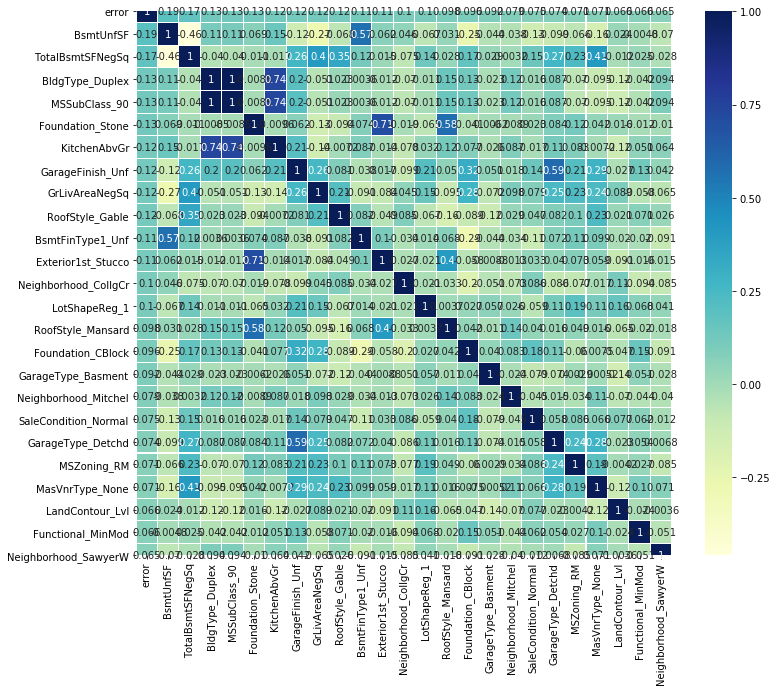

In [67]:
# setting up a correlation heatmap for error
error_corr = df_error.drop(['y_test', 'stacked_preds'], axis=1)

k=25
features = error_corr.corr().nlargest(k, 'error')['error'].index 
  
cm = np.corrcoef(error_corr[features].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = features.values,  
                              xticklabels = features.values,
           annot = True) 

In [68]:
error_corr.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,error
266,11764,8,7,1999,2007,348.0,4,3,4,3,...,0,0,0,0,0,0,0,0,0,-27384.624986
1144,10475,8,5,2008,2008,72.0,4,3,4,3,...,0,0,0,0,0,0,0,0,0,48643.009107
1010,15863,7,3,1920,1970,0.0,3,3,3,3,...,0,0,1,0,0,0,0,0,0,29734.760692
643,17503,6,5,1948,1950,0.0,3,3,3,3,...,0,0,0,0,0,0,0,0,0,31936.257743
832,45600,6,8,1908,1997,0.0,3,3,3,3,...,0,0,0,0,0,0,0,0,0,-79676.432932


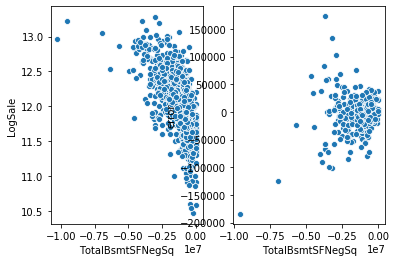

In [69]:
fig, axs = plt.subplots(1,2)
sns.scatterplot(data = df, x = 'TotalBsmtSFNegSq', y = 'LogSale', ax = axs[0])
sns.scatterplot(data = error_corr, x = 'TotalBsmtSFNegSq', y = 'error', ax = axs[1])

In [70]:
# after inspecting some of the data, it looks like I'll add a few more regression and interaction terms that might be able
# to anticipate the large error patters. # They will be a squared YearBuilt, that term * overall quality, and GrLivArea *
# OverallQuality

df = pd.read_csv('ml_ready.csv').drop(['Unnamed: 0', 'Unnamed: 0.1', 'GrLivAreaNegSq', 'TotalBsmtSFNegSq'], axis=1)
df['YearBuiltSq'] = df['YearBuilt']*df['YearBuilt']

categorical = []
for x in list(df.columns):
    if 'Non' in x:
        categorical.append(x)
    elif 'Has' in x:
        categorical.append(x)
    elif 'SubClass' in x:
        categorical.append(x)
    elif 'SaleConditionNor' in x:
        categorical.append(x)
    elif 'LandSlopeGtl' in x:
        categorical.append(x)
    elif 'LotShapeReg' in x:
        categorical.append(x)
    elif 'HeatingGas' in x:
        categorical.append(x)      
    elif 'CentralAir' in x:
        categorical.append(x)
for x in list(df.select_dtypes(include='object').columns):
    categorical.append(x)
categorical = list(set(categorical))

# merging converted dfs
df[categorical] = df[categorical].astype('object')
df_num = df.drop(categorical, axis = 1)
df = pd.concat([df[categorical],df_num], axis=1)

X = df.drop(['LogSale','SalePrice'],axis=1)
X = pd.get_dummies(X,drop_first=True)
y = df['LogSale']

In [71]:
# going to remake train test split in order to randomize and then re-run regressors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

In [72]:
# setting up our first level predictions

clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svm = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
predictions = []
pred_cols = []
numerical = list(X.select_dtypes(include = ['int64', 'float64']).columns)
categorical = list(X.select_dtypes(include = ['object']).columns)

preprocess = ColumnTransformer(transformers=
                              [('num', scaler, numerical),
                              ('cat', categorical_transformer, categorical)])

for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_train)))
    
first_level_preds = pd.DataFrame({'pred_lf': predictions[0],
                                 'pred_ridge': predictions[1],
                                 'pred_rf': predictions[2],
                                 'pred_ada': predictions[3],
                                 'pred_svr': predictions[4]})

X_train_1st = pd.concat([X_train.reset_index(),first_level_preds], axis=1).set_index(keys='index')

In [73]:
stacked = LinearRegression()
stacked.fit(X_train_1st,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
# creating predictions on the test set now for our second level predictions

clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svm = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
predictions = []
pred_cols = []
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_test)))
    
test_level_preds = pd.DataFrame({'pred_lf': predictions[0],
                                 'pred_ridge': predictions[1],
                                 'pred_rf': predictions[2],
                                 'pred_ada': predictions[3],
                                 'pred_svr': predictions[4]})

X_test_1st = pd.concat([X_test.reset_index(),test_level_preds], axis=1).set_index(keys='index')

In [75]:
results = cross_val_score(stacked, X_train, y_train, scoring = 'r2', cv = 5)
print(results)

[0.9002789  0.91759411 0.89749183 0.92420928 0.91658155]


In [76]:
stacked_preds = stacked.predict(X_test_1st)
print(np.sqrt(mean_squared_log_error(transformer(y_test),transformer(stacked_preds))))
print(r2_score(transformer(y_test),transformer(stacked_preds)))

0.14878798451689357
0.8208060853292225


In [77]:
# We're having mixed results with adjusting the higher level polynomial terms. Going to continue modifying
# However, given our previous CV scores, we should look primarily at dropping dimensionality for improving our models.
# My best guess is to remove some of the dummy variables from the models

In [78]:
df.select_dtypes(include = 'object').columns

Index(['BldgType', 'Fence', 'BsmtFinType1', 'Has3SsnPorch', 'LotShapeReg',
       'Has2ndFlr', 'GarageAreaBins', 'LandSlopeGtl', 'HasGarage', 'PoolQCNon',
       'LandContour', 'HasWoodDeck', 'SaleCondition', 'HasEnclosedPorch',
       'RoofStyle', 'Condition1', 'HeatingGas', 'MSZoning', 'LotAreaBins',
       'Foundation', 'HasBasement', 'GarageType', 'HouseStyle', 'Exterior1st',
       'CentralAir', 'GarageFinish', 'LotConfig', 'MasVnrType', 'Functional',
       'Alley', 'HasScreenPorch', 'HasOpenPorch', 'PavedDrive', 'MSSubClass',
       'Street', 'Neighborhood'],
      dtype='object')

In [79]:
df['GarageAreaBins'].unique()

array(['<600', '<900', '<300', '0', '<1200', '<10000'], dtype=object)

In [80]:
def basic_exploration(col, df):
    
    #for numeric variables
    
    if df[col].dtype == ('float64' or 'int64'):
        print("Distribution for Non-Null Values")
        print(df[df[col].isna()==False]['LogSale'].describe())
        print(sns.kdeplot(df[df[col].isna()==True]['LogSale'], label = 'Null Values'))
        print(sns.kdeplot(df[df[col].isna()==False]['LogSale'], label = 'With Information'))
    
    #for categorical variables
    
    elif df[col].dtype == 'object':
        print(df[col].unique())
        print()
        print("Distribution for Non-Null Values")
        print(round(df.groupby(col)['LogSale'].describe()),1)
        print()
        
        #loop for creating kde plots for categorical variables      
        print("Distribution plot for sale prices by categorical variable")
        try:
            print(sns.kdeplot(df[df[col].isna()==True]['LogSale'], label = 'Null Values'))
            for x in list(df[col].unique()):
                print(sns.kdeplot(df[df[col]==x]['LogSale'], label = x, alpha =.3))
        except:
            print(f'{x} does not contain enough data for a distribution plot.')
            pass

In [81]:
drop_list = []
drop_list.append('Condition1')
drop_list.append('HasGarage')
drop_list.append('LotConfig')
drop_list.append('RoofStyle')
drop_list.append('BsmtFinType1')
drop_list.append('Functional')
drop_list.append('LandContour')
drop_list.append('GarageType')

for x in list(df.select_dtypes(include = ['int64', 'float64']).columns):
    if '*' in x:
        drop_list.append(x)

In [82]:
# Re-running with less categorical variables

df = pd.read_csv('ml_ready.csv').drop(['Unnamed: 0', 'Unnamed: 0.1', 'GrLivAreaNegSq', 'TotalBsmtSFNegSq'], axis=1)
df = df.drop(drop_list, axis=1)
df['YearBuiltSq'] = df['YearBuilt']*df['YearBuilt']

categorical = []
for x in list(df.columns):
    if 'Non' in x:
        categorical.append(x)
    elif 'Has' in x:
        categorical.append(x)
    elif 'SubClass' in x:
        categorical.append(x)
    elif 'SaleConditionNor' in x:
        categorical.append(x)
    elif 'LandSlopeGtl' in x:
        categorical.append(x)
    elif 'LotShapeReg' in x:
        categorical.append(x)
    elif 'HeatingGas' in x:
        categorical.append(x)      
    elif 'CentralAir' in x:
        categorical.append(x)     
for x in list(df.select_dtypes(include='object').columns):
    categorical.append(x)
categorical = list(set(categorical))

# merging converted dfs
df[categorical] = df[categorical].astype('object')
df_num = df.drop(categorical, axis = 1)
df = pd.concat([df[categorical],df_num], axis=1)

X = df.drop(['LogSale','SalePrice'],axis=1)
X = pd.get_dummies(X,drop_first=True)
y = df['LogSale']

# going to remake train test split in order to randomize and then re-run regressors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

In [83]:
# setting up our first level predictions

clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svm = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
predictions = []
pred_cols = []
numerical = list(X.select_dtypes(include = ['int64', 'float64']).columns)
categorical = list(X.select_dtypes(include = ['object']).columns)

preprocess = ColumnTransformer(transformers=
                              [('num', scaler, numerical),
                              ('cat', categorical_transformer, categorical)])

for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_train)))
    
first_level_preds = pd.DataFrame({'pred_lf': predictions[0],
                                 'pred_ridge': predictions[1],
                                 'pred_rf': predictions[2],
                                 'pred_ada': predictions[3],
                                 'pred_svr': predictions[4]})

X_train_1st = pd.concat([X_train.reset_index(),first_level_preds], axis=1).set_index(keys='index')

stacked = LinearRegression()
stacked.fit(X_train_1st,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
# creating predictions on the test set now for our second level predictions

clf_lr = LinearRegression()
clf_ridge = Ridge()
clf_rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators=15)
clf_dtr = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 3)
clf_ada = AdaBoostRegressor(clf_dtr, n_estimators = 400, learning_rate=.1)
clf_svm = SVR(C=10, kernel = 'linear')

classifiers = [clf_lr, clf_ridge, clf_rf, clf_ada, clf_svr]
predictions = []
pred_cols = []
for x in classifiers:
    pipe = Pipeline(steps = 
                    [('preprocess', preprocess),
                     ('clf', x)])
    pred_name = 'pred_' + str(x)[0: str(x).find('(')]
    pred_cols.append(pred_name)
    pipe.fit(X_train,y_train)
    predictions.append(transformer(pipe.predict(X_test)))
    
test_level_preds = pd.DataFrame({'pred_lf': predictions[0],
                                 'pred_ridge': predictions[1],
                                 'pred_rf': predictions[2],
                                 'pred_ada': predictions[3],
                                 'pred_svr': predictions[4]})

X_test_1st = pd.concat([X_test.reset_index(),test_level_preds], axis=1).set_index(keys='index')

results = cross_val_score(stacked, X_train, y_train, scoring = 'r2', cv = 5)
print(results)

stacked_preds = stacked.predict(X_test_1st)
print(np.sqrt(mean_squared_log_error(transformer(y_test),transformer(stacked_preds))))
print(r2_score(transformer(y_test),transformer(stacked_preds)))

[0.89335213 0.88085993 0.85459149 0.88246337 0.87450078]
0.1568986031302001
0.7750946417258453
